# The project reproduces the optimization methodology in the paper [Large-Scale Price Optimization via Network Flow](https://papers.nips.cc/paper/6301-large-scale-price-optimization-via-network-flow.pdf)

In [0]:
import pandas as pd
import numpy as np
from google.colab import files
from fbprophet import Prophet
import io
import pickle

In [0]:
retail_data_input = pd.read_excel('retail.xlsx',sheet_name="dh Transaction Data",header= 1)

# Data Preparation
***
1. The data cotains sales record of each UPC (product)       for 70 stores and 5 categories.
2. We aggregate the data from all the stores to build        forecasting models at a market level
3. The assumptions here is that the pricing decisions are made at a higher heirarchy than store level **



In [0]:
 # Aggregation functions for different features 
get_indicator = lambda x: x.sum()/x.count()

agg_dict = {"UNITS": 'sum',
            "VISITS": 'sum',
            "HHS": 'sum',
            "SPEND":'sum',
            "PRICE": 'mean',
            "BASE_PRICE": 'mean',
            "FEATURE": [get_indicator],
            "DISPLAY": [get_indicator],
            "TPR_ONLY": [get_indicator]
            }

retail_data_input.dropna(axis=1,how="all",inplace=True)
retail_data = retail_data_input.groupby(["WEEK_END_DATE","UPC"]).agg(agg_dict)
retail_data = retail_data.reset_index()
retail_data.columns = retail_data.columns.get_level_values(0)
retail_data.head()

,WEEK_END_DATE,UPC,UNITS,VISITS,HHS,SPEND,PRICE,BASE_PRICE,FEATURE,DISPLAY,TPR_ONLY
0,2009-01-14,1111009477,4143,3720,3655,5455.50,1.280000,1.282468,0.0,0.493506,0.012987
1,2009-01-14,1111009497,4527,4014,3945,5936.13,1.280130,1.299870,0.0,0.480519,0.051948
2,2009-01-14,1111009507,1550,1451,1430,1999.97,1.278182,1.280390,0.0,0.233766,0.000000
3,2009-01-14,1111035398,227,203,203,846.74,3.970645,4.507419,0.0,0.016129,0.548387
4,2009-01-14,1111038078,389,323,322,776.28,2.156197,2.516056,0.0,0.014085,0.408451


#Merge with product data to get category and other product attributes

In [0]:
product_data = pd.read_excel('retail.xlsx',sheet_name="dh Products Lookup",header= 1)
product_data.dropna(axis=1,how="all",inplace=True)
data_with_catg = pd.merge(retail_data,product_data,how='left',on=["UPC"])
data_with_catg.head()

,WEEK_END_DATE,UPC,UNITS,VISITS,HHS,SPEND,PRICE,BASE_PRICE,FEATURE,DISPLAY,TPR_ONLY,DESCRIPTION,MANUFACTURER,CATEGORY,SUB_CATEGORY,PRODUCT_SIZE
0,2009-01-14,1111009477,4143,3720,3655,5455.50,1.280000,1.282468,0.0,0.493506,0.012987,PL MINI TWIST PRETZELS,PRIVATE LABEL,BAG SNACKS,PRETZELS,15 OZ
1,2009-01-14,1111009497,4527,4014,3945,5936.13,1.280130,1.299870,0.0,0.480519,0.051948,PL PRETZEL STICKS,PRIVATE LABEL,BAG SNACKS,PRETZELS,15 OZ
2,2009-01-14,1111009507,1550,1451,1430,1999.97,1.278182,1.280390,0.0,0.233766,0.000000,PL TWIST PRETZELS,PRIVATE LABEL,BAG SNACKS,PRETZELS,15 OZ
3,2009-01-14,1111035398,227,203,203,846.74,3.970645,4.507419,0.0,0.016129,0.548387,PL BL MINT ANTSPTC RINSE,PRIVATE LABEL,ORAL HYGIENE PRODUCTS,MOUTHWASHES (ANTISEPTIC),1.5 LT
4,2009-01-14,1111038078,389,323,322,776.28,2.156197,2.516056,0.0,0.014085,0.408451,PL BL MINT ANTSPTC RINSE,PRIVATE LABEL,ORAL HYGIENE PRODUCTS,MOUTHWASHES (ANTISEPTIC),500 ML


In [0]:
#@title Enter Category for Pricing
category = 'BAG SNACKS'#@param {type:"string"}

In [0]:
#@title Enter Periods for Train and Test
Total_Periods = 156#@param {type:"integer"}
Test_Periods =  13#@param {type:"integer"}
Train_End = 142#@param {type:"integer"}


#Helper functions to fit model to the data and data preparation

In [0]:
def fill_na_with_mean(feature):
  ind = pd.isna(feature)
  if sum(ind):
    feature[ind] = feature.mean()
  return feature

def scale_to_one(feature):
  return feature/feature.sum()

def fit_model(input_data, regressors):
  # Fit model and use federal holidays and custom monthly seasonality 
  m = Prophet()
  m.add_country_holidays(country_name='US')
  # period determines one cycle and fourier order determines sub cycles (here 3 cycles within 5 period)
  m.add_seasonality(name="monthly",period=5,fourier_order=3)
  for regressor in regressors:
    m.add_regressor(regressor)
  m.fit(input_data.iloc[0:Total_Periods-Test_Periods])
  forecast = m.predict(input_data)
  mape = ((input_data.iloc[-Test_Periods:]['y'] - 
           forecast.iloc[-Test_Periods:]['yhat']).apply(abs)/input_data.iloc[-Test_Periods:]['y']).mean()
  return mape, m, forecast

def add_price_features(catg_data):
  # Add price features (substitutes and complimentary products) to every model
  # we assume every product (UPC) in the given category is either substitute or complimentary product
  catg_data['UPC_label'] = catg_data.apply(lambda x: '_'.join(['PRICE',str(x.UPC)]),axis = 1)
  columns_to_join = ['WEEK_END_DATE','UPC','UNITS', 'VISITS', 'HHS', 'SPEND','FEATURE', 'DISPLAY', 'TPR_ONLY']
  output_data = pd.merge(catg_data.pivot(index='WEEK_END_DATE',
                          columns='UPC_label',values='PRICE').reset_index(),
                           catg_data.loc[:,columns_to_join], on='WEEK_END_DATE',how='left')
  return output_data


def prep_data_for_model(upc_data):
    # Rename and clean the data for forecasting (using propet)
    # scale TRP, DISPLAY and FEATURE between (0, 1)

    upc_data.rename(columns={"WEEK_END_DATE":"ds","UNITS":"y"},inplace=True)
    upc_data.reset_index(inplace=True)
    upc_data.drop(columns='index',inplace=True)
    price_index = upc_data.columns.map(lambda x: "PRICE" in x)
    regressors = list(upc_data.columns[price_index]) + ['FEATURE', 'DISPLAY', 'TPR_ONLY']
    target = ['ds','y']
    upc_data = upc_data.loc[:,regressors + target]
    upc_data = upc_data.apply(fill_na_with_mean,axis=0)
    upc_data.loc[:,regressors] = upc_data.loc[:,regressors].apply(scale_to_one,axis=0)
    upc_data.dropna(axis=1,how="all",inplace=True)
    return upc_data


def get_models_for_category(category, data_with_catg):
  # Get the data for given category and build models for 
  # each upc within the data
  Model_dict = {}
  Mape_dict = {}
  Model_forecast = {}
  data = data_with_catg.groupby(['CATEGORY']).get_group(category)
  data_cat = add_price_features(data)
  upcs = pd.unique(data_cat['UPC'])
  for upc in upcs:
    df_upc = data_cat.loc[data_cat['UPC']==upc,:].copy()
    df_upc = prep_data_for_model(df_upc)
    target = ['ds','y']
    regressors = set(df_upc.columns).difference(set(target))
    mape,m,forecast = fit_model(df_upc,regressors)
    Model_dict[(category,upc)] = m
    Mape_dict[(category,upc)] = mape
    Model_forecast[(category,upc)] = forecast
  return Model_dict, Mape_dict,Model_forecast,upcs





#Forecast for the scenarios and get base prices from the data
The model for UPC $i$ is 

\begin{align}
y^i(t) = g^i(t) + s^i(t) + h^i(t) + \sum_{j \in U} \beta_jp_j(t) + \epsilon(t)
\end{align}
where $p_j(t)$ is the price of product $j$. 

The link to the documentation is 
[Prophet Model](https://facebook.github.io/prophet/)

In [0]:
# Forecast for the scenarios and get base prices from the data
Model_dict, Mape_dict, Forecast_dict,upcs = get_models_for_category(category,data_with_catg)

def get_base_price(upc,retail_data,week_index = Train_End):
  # Get the base price rather than actual price to using for future discounts. Discounts are always given on 
  # base price in retail
  return retail_data.loc[retail_data['UPC'] == upc,'BASE_PRICE'].reset_index().iloc[week_index]['BASE_PRICE']

Base_Price = {}
for upc in upcs:
  Base_Price[upc] = get_base_price(upc,data_with_catg)

Mape_dict

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

INFO:numexpr.utils:NumExpr defaulting to 2 threads.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality

{('BAG SNACKS', 1111009477): 0.06739881797594555,
 ('BAG SNACKS', 1111009497): 0.22288564960867704,
 ('BAG SNACKS', 1111009507): 0.18543799894247706,
 ('BAG SNACKS', 2840002333): 0.12286604011343383,
 ('BAG SNACKS', 2840004768): 0.1689058041611475,
 ('BAG SNACKS', 2840004770): 0.17325842896758278,
 ('BAG SNACKS', 7027312504): 0.09139296830046953,
 ('BAG SNACKS', 7027316204): 0.10222616165926562,
 ('BAG SNACKS', 7027316404): 0.0531704419403577,
 ('BAG SNACKS', 7110410455): 0.12248704773048708,
 ('BAG SNACKS', 7110410470): 0.13712922099168262,
 ('BAG SNACKS', 7110410471): 0.21380767811536655,
 ('BAG SNACKS', 7797502248): 0.5143383879609578,
 ('BAG SNACKS', 7797508004): 0.37807263344480097,
 ('BAG SNACKS', 7797508006): 0.22783614722951467}

# Take a look at the model Plots for any UPC

In [0]:
#@title Enter the UPC number to look at plots
UPC = 1111009477#@param {type:"integer"}


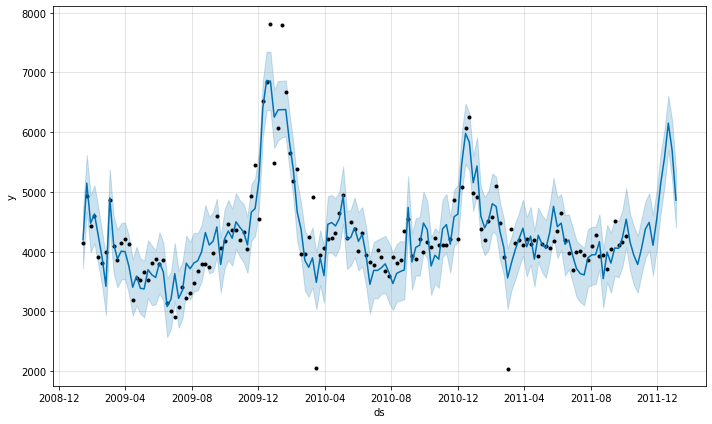

In [0]:
upc_model = Model_dict[(category,UPC)]
forecast = Forecast_dict[(category,UPC)]

fig1 = upc_model.plot(forecast)

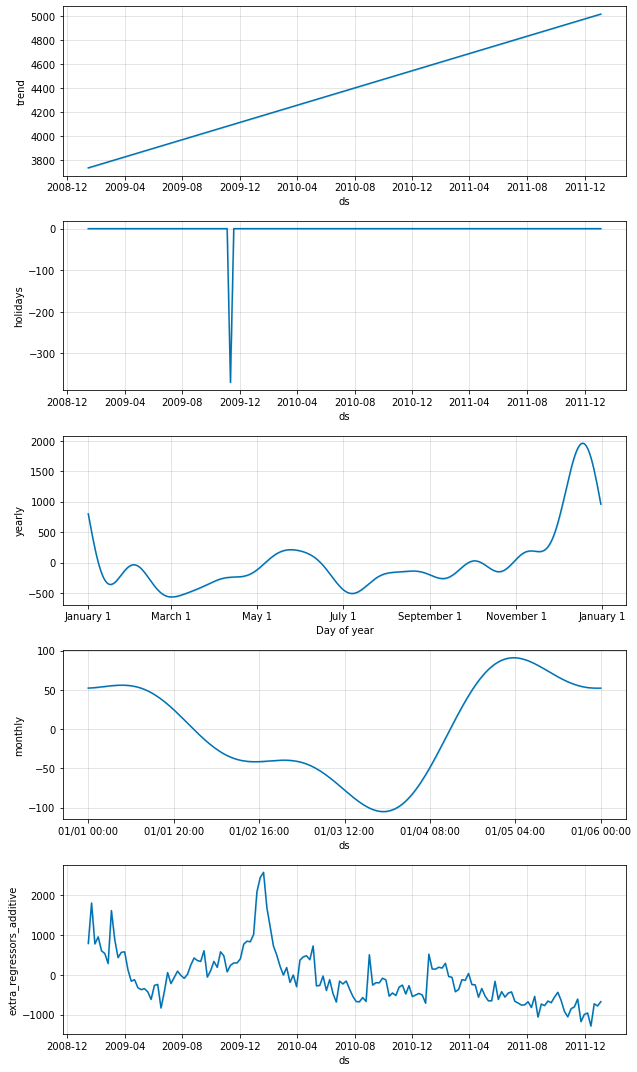

In [0]:
fig2 = upc_model.plot_components(forecast)

In [0]:

def get_data_for_simulation(category,upc, data_with_catg):
  # Get the data for given category and build models for 
  # each upc within the data
  data = data_with_catg.groupby(['CATEGORY']).get_group(category)
  data_cat = add_price_features(data)
  df_upc = data_cat.loc[data_cat['UPC']==upc,:].copy()
  df_upc = prep_data_for_model(df_upc)
  return df_upc

def get_future_data(data_upc,upc_main,upc_subs,upc_main_discount,upc_subs_discount,Base_Price = Base_Price):
  price_index = data_upc.columns.map(lambda x: "PRICE" in x)
  Price_regressors = list(data_upc.columns[price_index])
  for col in Price_regressors:
    upc = int(col.split("_")[1])
    if upc == upc_main:
      data_upc.loc[:,col] = data_upc.loc[:,col].apply(lambda x: (1-upc_main_discount)*Base_Price[upc])
    elif upc == upc_subs:
      data_upc.loc[:,col] = data_upc.loc[:,col].apply(lambda x: (1-upc_subs_discount)*Base_Price[upc])
    else:
      data_upc.loc[:,col] = data_upc.loc[:,col].apply(lambda x: Base_Price[upc])
  return data_upc

#Simulating model for different price points
Use pre-computed forecast (takes time to run)

In [0]:
discount_levels = [0,0.1,0.2,0.3]
Simulation_dict = {}
for upc in upcs:
  df_upc = get_data_for_simulation(category,upc,data_with_catg)
  df_upc_future = df_upc.iloc[-Test_Periods:]
  for upc_sub in set(upcs).difference([upc]):
      for i in discount_levels:
        for j in discount_levels:
            data_future = get_future_data(df_upc_future,upc,upc_sub,i,j)
            model = Model_dict[(category,upc)]
            forecast = model.predict(data_future)
            volume = forecast.iloc[-Test_Periods:].loc[:,'yhat'].sum()
            Simulation_dict[(upc,upc_sub,int(i*10),int(j*10))] = volume
  print("upc: {} completed !!!".format(upc))
  
with open('forecast_dict.pickle', 'wb') as handle:
    pickle.dump(Simulation_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Mathematical model

**Definition**:

$U$ be the set of UPCS in the given category (Bag Snacks)

$D \in \{0,10,20,30\}$ be the set of discount percentage available for all the UPCS 

$V^{i,j}_{u,v}$ is the estimated volume of UPC $i$, with $u$ and $v$ percent discount for UPC $i$ and $j$ respectively

$P^{i}_{u}$ is the price of UPC $i$ at $u$ percent discount

$x^{i}_{u}$ is the variable that takes value 1 if the UPC $i$ is at discount percent $u$ or 0 otherwise


\begin{align}
\min &\sum_{i \in U} \sum_{j \in U, i \ne j} \sum_{u \in D} \sum_{v \in D}x^{i}_{u}P^{i}_{u}V^{i,j}_{u,v}x^{j}_{v}\\
\text{s.t} ~~&\sum_{u \in D} x^{i}_{u} = 1 ~~~~~\forall i \in U\\
{} & x^{i}_{u} \in \{0, 1\}
\end{align}
The formulation is quadratic BIP and we can linearize the product of binary variables using the following set of equation

\begin{align}
  &z^{i,j}_{u,v} \le x^{i}_{u} ~~~~  \forall i,j \in U, u,v \in D ~~\text{(relax 1)}\\
  &z^{i,j}_{u,v} \le x^{j}_{v}~~~~  \forall i,j \in U, u,v \in D ~~\text{(relax 2)}\\
  &z^{i,j}_{u,v} \ge x^{i}_{u} + x^{j}_{v} - 1 ~~~~ \forall i,j \in U, u,v \in D ~~ \text{(relax 3)}
\end{align}


# Pyomo and open source cbc solver installation and setup

In [0]:
import shutil
import sys
import os.path

if not shutil.which("pyomo"):
    !pip install -q pyomo
    assert(shutil.which("pyomo"))

if not (shutil.which("cbc") or os.path.isfile("cbc")):
    if "google.colab" in sys.modules:
        !apt-get install -y -qq coinor-cbc
    else:
        try:
            !conda install -c conda-forge coincbc 
        except:
            pass

assert(shutil.which("cbc") or os.path.isfile("cbc"))
from pyomo.environ import *
from pyomo.gdp import *
from pyomo.opt import SolverFactory

     |████████████████████████████████| 2.4MB 5.0MB/s 
     |████████████████████████████████| 256kB 61.4MB/s 
     |████████████████████████████████| 51kB 6.9MB/s 
     |████████████████████████████████| 163kB 55.5MB/s 
Selecting previously unselected package coinor-libcoinutils3v5.
(Reading database ... 134983 files and directories currently installed.)
Preparing to unpack .../0-coinor-libcoinutils3v5_2.10.14+repack1-1_amd64.deb ...
Unpacking coinor-libcoinutils3v5 (2.10.14+repack1-1) ...
Selecting previously unselected package coinor-libosi1v5.
Preparing to unpack .../1-coinor-libosi1v5_0.107.9+repack1-1_amd64.deb ...
Unpacking coinor-libosi1v5 (0.107.9+repack1-1) ...
Selecting previously unselected package coinor-libclp1.
Preparing to unpack .../2-coinor-libclp1_1.16.11+repack1-1_amd64.deb ...
Unpacking coinor-libclp1 (1.16.11+repack1-1) ...
Selecting previously unselected package coinor-libcgl1.
Preparing to unpack .../3-coinor-libcgl1_0.59.10+repack1-1_amd64.deb ...
Unpacking coi

In [0]:
with open('forecast_dict.pickle', 'rb') as handle:
    Simulation_dict = pickle.load(handle)


In [0]:

Discount = [0,1,2,3]
# Create Price dictionary
Price_Dict = {}
upcs = list(Base_Price.keys())
for upc in Base_Price.keys():
  for discount in Discount:
    Price_Dict[(upc,discount)] = Base_Price[upc]*(1-discount/10)


## Pyomo model building
opt = SolverFactory('cbc')
model = AbstractModel()
model.UPC = Set()
model.Discount = Set()
model.Cross_Set = Set(dimen=4)
model.Unary_Set = Set(dimen=2)
model.Coeff_Unary = Param(model.Unary_Set,default=0)
model.Coeff_Cross = Param(model.Cross_Set,default=0)

model.Var_upc_discount = Var(model.Unary_Set,within=Binary)
model.Var_Cross = Var(model.Cross_Set,within=Binary)

def relax_1(model,upc_i,upc_j, discount_u, discount_v):
  if (upc_i,upc_j, discount_u,discount_v) in model.Cross_Set:
    return model.Var_Cross[upc_i,upc_j,discount_u,discount_v] - model.Var_upc_discount[upc_i,discount_u] <= 0
  else:
    return None


def relax_2(model,upc_i,upc_j, discount_u,discount_v):
  if (upc_i,upc_j, discount_u,discount_v) in model.Cross_Set:
    return model.Var_Cross[upc_i,upc_j, discount_u,discount_v] - model.Var_upc_discount[upc_j,discount_v] <= 0
  else:
    return None

def relax_3(model,upc_i,upc_j, discount_u,discount_v):
  if (upc_i,upc_j, discount_u,discount_v) in model.Cross_Set:
    return model.Var_Cross[upc_i,upc_j, discount_u,discount_v] - model.Var_upc_discount[upc_i,discount_u] - model.Var_upc_discount[upc_j,discount_v]  + 1 >= 0
  else:
    return None

def one_discount_per_upc(model, upc):
  return sum(model.Var_upc_discount[upc,discount] for discount in model.Discount) == 1


def Volume(model):
  return summation(model.Coeff_Cross, model.Var_Cross)

def Revenue(model):
  return sum(model.Coeff_Cross[upc_i,upc_j,discount_u,discount_v]*
             model.Var_Cross[upc_i,upc_j,discount_u,discount_v]*model.Coeff_Unary[upc_i,discount_u] 
             for upc_i,upc_j,discount_u,discount_v in model.Cross_Set)

model.relax1 = Constraint(model.Cross_Set,rule=relax_1)
model.relax2 = Constraint(model.Cross_Set,rule=relax_2)
model.relax3 = Constraint(model.Cross_Set,rule=relax_3)
model.OneDiscount = Constraint(model.UPC,rule=one_discount_per_upc)
model.TotalVolume = Objective(rule=Revenue,sense=maximize)

Unary_dict = {}
for upc in upcs:
   for discount in Discount:
      Unary_dict[(upc,discount)] = 0

data = {None:{
        'UPC': {None:upcs},
        'Discount': {None: Discount},
        'Unary_Set': {None: [(upc,discount) for upc in upcs for discount in Discount]},
        'Cross_Set': {None: [*Simulation_dict]},
        'Coeff_Unary': Price_Dict,
        'Coeff_Cross': Simulation_dict,}
}


instance = model.create(data)
result = opt.solve(instance)

def write_out_csv(filename,instance):
  with open(filename,'w') as f:
    for upc, discount in instance.Unary_Set:
      var_value = value(instance.Var_upc_discount[upc,discount])
      if var_value:
        f.write('%s, %s, %s\n' %(upc,discount*10))
  
def print_result(instance):
  for upc, discount in instance.Unary_Set:
    var_value = value(instance.Var_upc_discount[upc,discount])
    if var_value:
        print("UPC: {} is recommended at {} percent discount".format(upc,discount*10))



Model.create_instance() to create a concrete instance from an abstract
model.  You do not need to call Model.create() for a concrete model.


    Model.create_instance() to create a concrete instance from an abstract
    model.  You do not need to call Model.create() for a concrete model.


# Results and explanation

In [0]:
print_result(instance)


UPC: 1111009477 is recommended at 20 percent discount
UPC: 1111009497 is recommended at 30 percent discount
UPC: 1111009507 is recommended at 30 percent discount
UPC: 2840002333 is recommended at 30 percent discount
UPC: 2840004768 is recommended at 30 percent discount
UPC: 2840004770 is recommended at 0 percent discount
UPC: 7027312504 is recommended at 0 percent discount
UPC: 7027316204 is recommended at 0 percent discount
UPC: 7027316404 is recommended at 0 percent discount
UPC: 7110410455 is recommended at 30 percent discount
UPC: 7110410470 is recommended at 0 percent discount
UPC: 7110410471 is recommended at 0 percent discount
UPC: 7797502248 is recommended at 30 percent discount
UPC: 7797508004 is recommended at 30 percent discount
UPC: 7797508006 is recommended at 30 percent discount


#Generate Heat Map to explain the results (Complementary and Cannibalization)


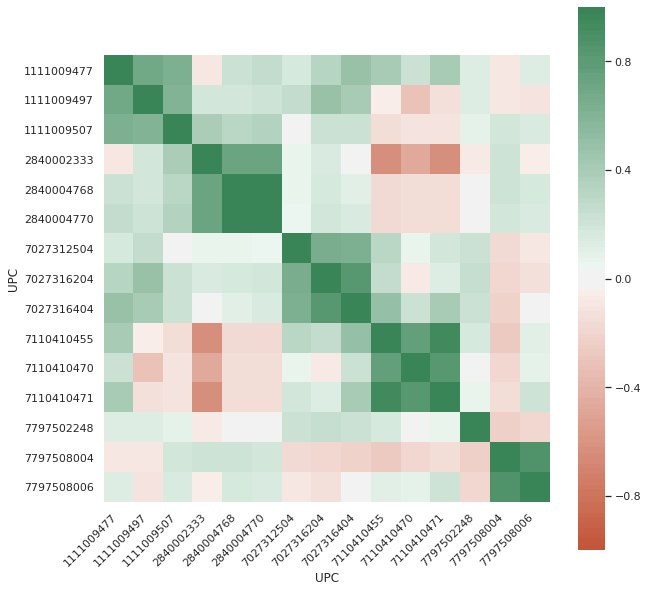

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
data = data_with_catg.groupby(['CATEGORY']).get_group(category)
corr = data.pivot(index='WEEK_END_DATE',columns='UPC',values='UNITS').corr()
fig, ax = plt.subplots(figsize=(10,10))
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 500, n=100),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);